In [1]:
import pandas as pd
import numpy as np
import altair as alt

from Bio import SeqIO
from IPython.display import display, Image
import matplotlib.pyplot as plt
import dmslogo
from dmslogo.colorschemes import CBPALETTE, ValueToColorMap

import theme
alt.themes.register('main_theme', theme.main_theme)
alt.themes.enable('main_theme')

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [5]:
# get cell entry / stability data to merge
phenotypes = pd.read_csv(
    '../results/summaries/Phenotypes.csv'
).drop(columns=['sera escape', 'sequential_site'])

phenotypes.head()

,site,wildtype,mutant,MDCKSIAT1 cell entry,pH stability,region,nt changes to codon
0,1,Q,A,-0.1226,0.004237,HA1,2
1,1,Q,C,-0.5732,-0.014300,HA1,3
2,1,Q,D,0.2550,-0.021900,HA1,2
3,1,Q,E,0.2941,0.006890,HA1,1
4,1,Q,F,-0.7141,-0.001402,HA1,3


In [8]:
# get MA22 escape data
sera_of_interest = ['SCH23-y2021-s056', 'SCH23-y2016-s037', 'SCH23-y2009-s002', 'SCH23-y2009-s007']

escape = pd.read_csv(
    '../results/summaries/Phenotypes_per_antibody_escape.csv'
).drop(columns=['antibody_set']).rename(
    columns={'antibody' : 'sera'}
).assign(
    mutation=lambda x: x['wildtype'] + x['site'].astype(str) + x['mutant'],
)[['sera', 'site', 'wildtype', 'mutant', 'mutation', 'escape']].query(
    'sera in @sera_of_interest'
)

ma22_escape_df = pd.merge(
    escape,
    phenotypes,
    on=['site', 'wildtype', 'mutant'],
    how='left'
).query(
    '`MDCKSIAT1 cell entry` > -3'
).assign(
    sum_site_escape=lambda x: x.groupby(['sera', 'site'])['escape'].transform('sum'),
).dropna()

# sites to show in the logoplot
sites_of_interest = np.sort(ma22_escape_df.query(
    '(sum_site_escape > 4 or site in [131, 140, 145, 205]) and site < 245'
)['site'].unique())

ma22_escape_df = ma22_escape_df.assign(
    show_site=lambda x: x["site"].isin(sites_of_interest),
    site_label=ma22_escape_df['wildtype'] + ma22_escape_df['site'].astype(str),
)
ma22_escape_df.head()

,sera,site,wildtype,mutant,mutation,escape,MDCKSIAT1 cell entry,pH stability,region,nt changes to codon,sum_site_escape,show_site,site_label
0,SCH23-y2009-s002,1,Q,A,Q1A,0.09797,-0.1226,0.004237,HA1,2,-0.396391,False,Q1
1,SCH23-y2009-s002,1,Q,C,Q1C,-0.06492,-0.5732,-0.014300,HA1,3,-0.396391,False,Q1
2,SCH23-y2009-s002,1,Q,D,Q1D,0.03337,0.2550,-0.021900,HA1,2,-0.396391,False,Q1
3,SCH23-y2009-s002,1,Q,E,Q1E,-0.01448,0.2941,0.006890,HA1,1,-0.396391,False,Q1
4,SCH23-y2009-s002,1,Q,F,Q1F,-0.11380,-0.7141,-0.001402,HA1,3,-0.396391,False,Q1


### Line plots

In [9]:
site_to_i = {site: i for i, site in enumerate(ma22_escape_df['site'].unique())}
ma22_escape_df = ma22_escape_df.assign(_stat_site_order=lambda x: x["site"].map(site_to_i))

base = alt.Chart(
    ma22_escape_df[['sera', 'site', 'wildtype', 'sum_site_escape', 'region', 'show_site', '_stat_site_order']].drop_duplicates()
).encode(
    alt.X(
        "site:O",
        sort=alt.EncodingSortField(field="_stat_site_order", order="ascending"), 
        title='Site',
        axis=alt.Axis(
            labelAngle=0,
            values=[1, 50, 100, 150, 200, 250, 300, 351, 400, 450, 500],
            tickCount=11,
        )
    ),
    alt.Y(
        "sum_site_escape:Q", 
        title='Sum of escape effects',
        axis=alt.Axis(
            tickCount=4
        )
    ),
    tooltip=['sera', 'wildtype', "site", "sum_site_escape", "region"],
)

line = base.mark_line(opacity=0.5, stroke='#999999', size=1).encode(
    detail='sera'
)

highlight_points = base.transform_filter(
    alt.datum.show_site == True
).mark_circle(size=50, opacity=0.7, color='#DC322F', stroke='black', strokeWidth=0)

background_points = base.transform_filter(
    alt.datum.show_site == False
).mark_circle(size=25, opacity=0.3, color='gray')

# Horizontal line at y = 0
hline = alt.Chart().mark_rule(
        color='black',
        size=1.25,
        opacity=1,
        strokeDash=[5,5]
    ).encode(y=alt.Y(datum=0))

unfacet_chart = (
    (line + background_points + highlight_points + hline)
    .properties(width=800, height=150)
)

unfacet_chart.display()

alt.LayerChart(...)

In [10]:
all_points = base.mark_circle(size=25, opacity=0.5, color='gray')

chart = (
    (line + all_points + hline)
    .properties(width=500, height=80)
    .facet(
        row=alt.Row(
            "sera:N", 
            title="Site escape",
            header=alt.Header(
                labelFontSize=10,
                labelFontWeight="normal",
                titleFontSize=16,
                titleFontWeight="normal"
            )
        ),
    )
    .resolve_scale(
        y='independent',
        x='independent'
    )
).configure_axis(
    title=None
)

chart.display()

alt.FacetChart(...)

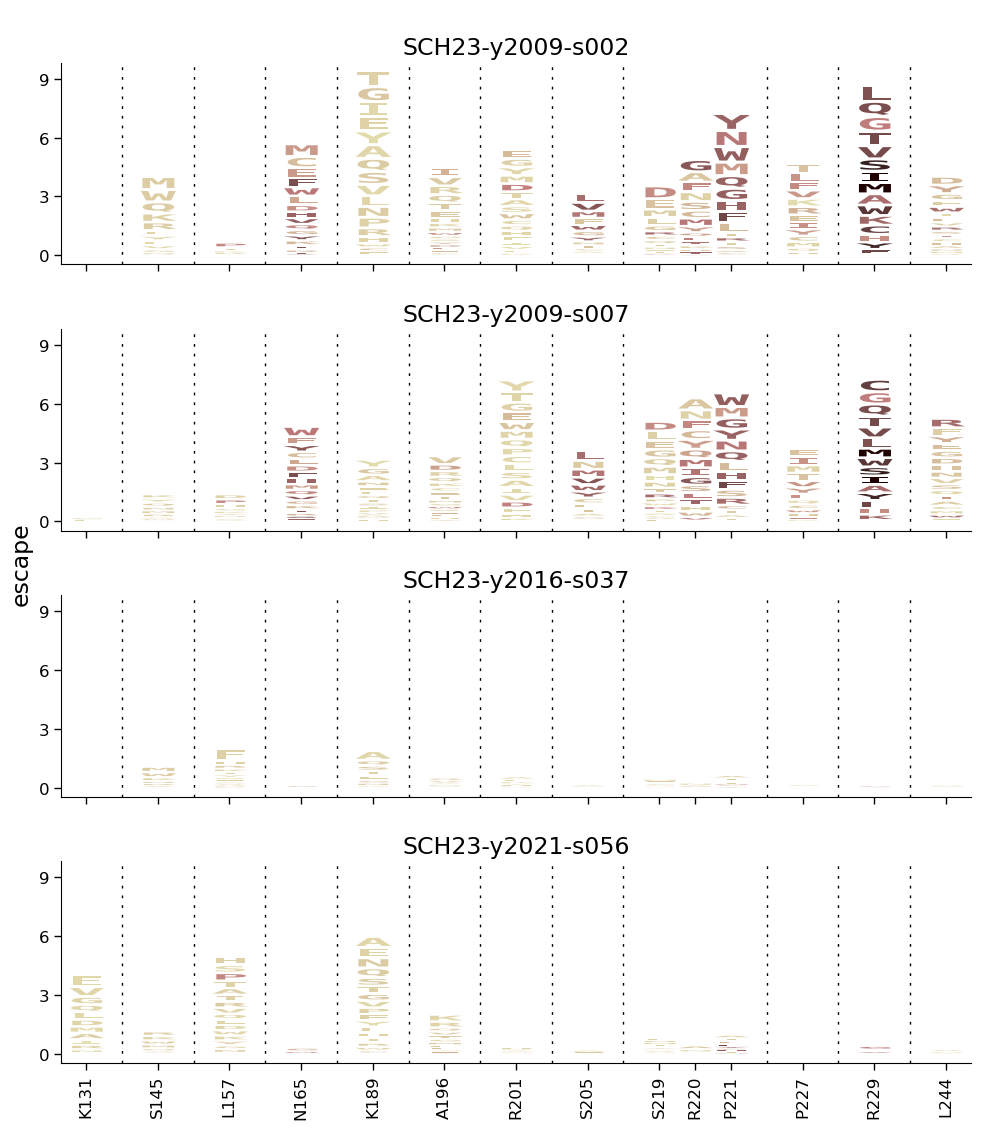

In [11]:
map = ValueToColorMap(
    ma22_escape_df['pH stability'].min(), 
    ma22_escape_df['pH stability'].max()+0.3,
    'pink'
)

logoplot_df = ma22_escape_df.assign(
    color=lambda x: x['pH stability'].map(map.val_to_color),
    site_label=ma22_escape_df['wildtype'] + ma22_escape_df['site'].astype(str),
    show_site=lambda x: x["site"].isin(sites_of_interest)
).query('site not in [140, 285]')

def generate_facet_logo_plot(df, output_file_name):
    """Generate logo plot and save as a file."""

    draw_logo_kwargs = {
        "letter_col": "mutant",
        "color_col": "color",
        "xtick_col": "site_label",
        "letter_height_col": "escape",
        "xlabel": "",
        "clip_negative_heights": True,
    }
    fig, ax = dmslogo.facet_plot(
        data=df,
        x_col="site",
        gridrow_col="sera",
        share_ylim_across_rows=True,
        show_col="show_site",
        draw_logo_kwargs=draw_logo_kwargs,
    )
    fig
    fig.savefig(output_file_name, bbox_inches="tight", format="svg")

generate_facet_logo_plot(logoplot_df, 'figures/ma22_sera_escape_logo.svg')

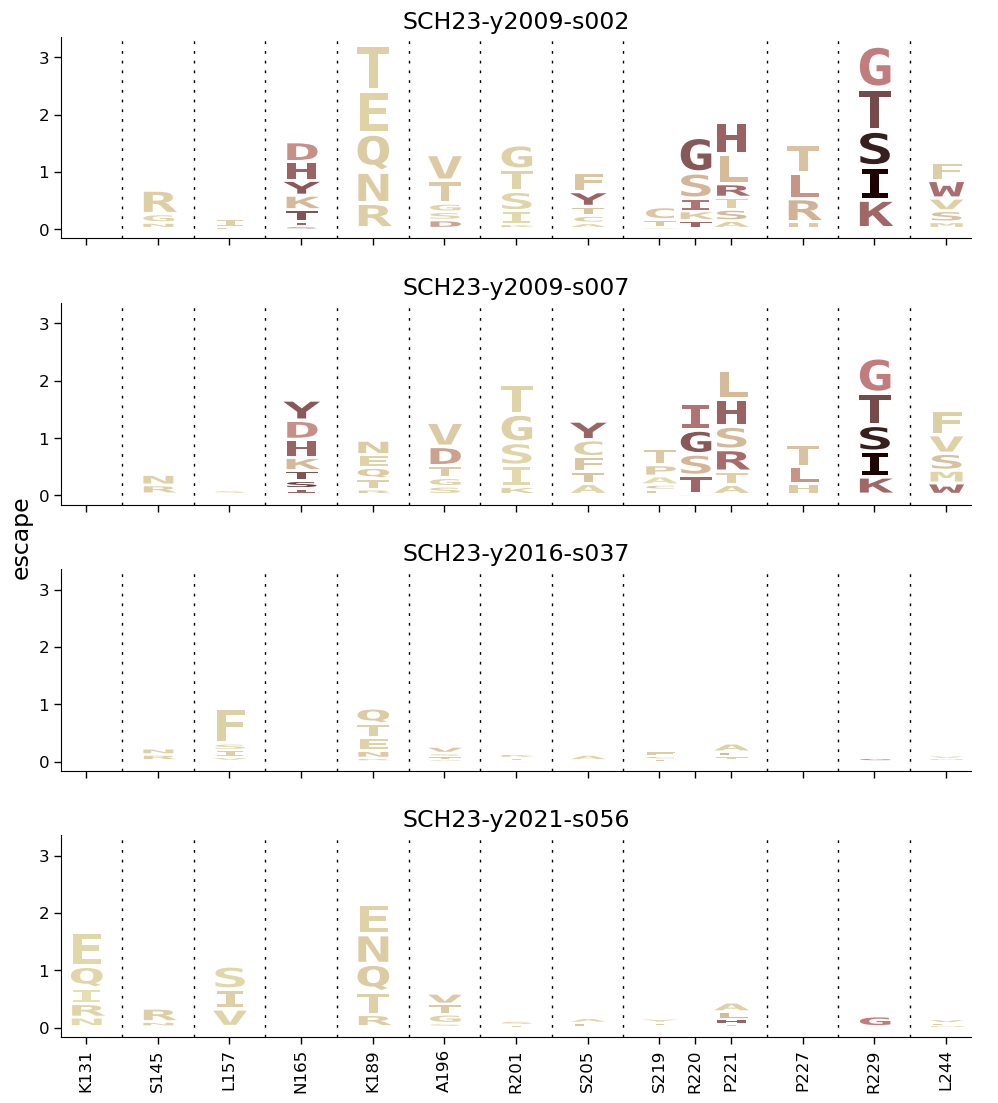

In [12]:
sna_ma22_escape_df = ma22_escape_df.query(
    '`nt changes to codon` == 1'
)

logoplot_df = sna_ma22_escape_df.assign(
    color=lambda x: x['pH stability'].map(map.val_to_color),
    site_label=sna_ma22_escape_df['wildtype'] + sna_ma22_escape_df['site'].astype(str),
    show_site=lambda x: x["site"].isin(sites_of_interest)
).query('site not in [140, 285]')

generate_facet_logo_plot(logoplot_df, 'figures/sna_ma22_sera_escape_logo.svg')

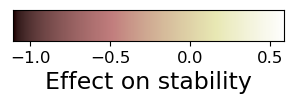

In [13]:
scale_bar, _ = map.scale_bar(orientation="horizontal", label="Effect on stability")
scale_bar.savefig('figures/ma22_scalebar.svg', bbox_inches="tight", format="svg")

In [14]:
pe09_escape_df = pd.read_csv('data/perth09_avg_sel_tidy.csv', low_memory=False).assign(
    site=lambda x: x["site"].apply(
        lambda s: int(s.split(")")[1]) + 329 if s.startswith("(HA2)") else int(s)
    )
).sort_values(by=["site", "mutation"]).reset_index(drop=True)

human_sera_samples = ['2015-age-25-vacc', '2015-age-29-vacc', '2015-age-48-vacc', '2015-age-49-vacc', 
                      '2010-age-21', '2009-age-53', '2009-age-64', '2009-age-65']

human_pe09_escape_df = pe09_escape_df.query('serum_name_formatted in @human_sera_samples')[
    ['serum_name_formatted', 'site', 'wildtype', 'mutation', 'mutdiffsel']
].reset_index(drop=True).rename(
    columns={
        'serum_name_formatted': 'sera',
        'mutation': 'mutant',
        'mutdiffsel': 'escape',
    }
).assign(
    mutation=lambda x: x['wildtype'] + x['site'].astype(str) + x['mutant']
)[['sera', 'site', 'wildtype', 'mutant', 'mutation', 'escape']]

human_pe09_escape_df.head()

,sera,site,wildtype,mutant,mutation,escape
0,2015-age-25-vacc,-16,M,A,M-16A,-0.18010
1,2015-age-29-vacc,-16,M,A,M-16A,-0.42641
2,2015-age-48-vacc,-16,M,A,M-16A,-0.20077
3,2015-age-49-vacc,-16,M,A,M-16A,-0.43035
4,2010-age-21,-16,M,A,M-16A,-0.50409


In [15]:
# read in Perth/2009 data
#sera_of_interest = ['2015-age-25-vacc', '2010-age-21', '2009-age-64']
sera_of_interest = ['2015-age-25-vacc', '2015-age-29-vacc', '2015-age-48-vacc', '2015-age-49-vacc', 
                      '2010-age-21', '2009-age-53', '2009-age-64', '2009-age-65']

pe09_escape_df = pd.merge(
    human_pe09_escape_df,
    phenotypes[['site', 'mutant', 'MDCKSIAT1 cell entry', 'pH stability']],
    on=['site', 'mutant'],
    how='left'
).assign(
    sum_site_escape=lambda x: x.groupby(["sera", "site"])["escape"].transform("sum")
).query(
    'sera in @sera_of_interest'
).dropna()

pe09_escape_df.head()

,sera,site,wildtype,mutant,mutation,escape,MDCKSIAT1 cell entry,pH stability,sum_site_escape
2560,2015-age-25-vacc,1,Q,A,Q1A,-0.880480,-0.1226,0.004237,-2.472715
2564,2010-age-21,1,Q,A,Q1A,0.216640,-0.1226,0.004237,-2.958608
2566,2009-age-64,1,Q,A,Q1A,-1.224900,-0.1226,0.004237,-6.455936
2568,2015-age-25-vacc,1,Q,C,Q1C,0.175070,-0.5732,-0.014300,-2.472715
2572,2010-age-21,1,Q,C,Q1C,0.075402,-0.5732,-0.014300,-2.958608


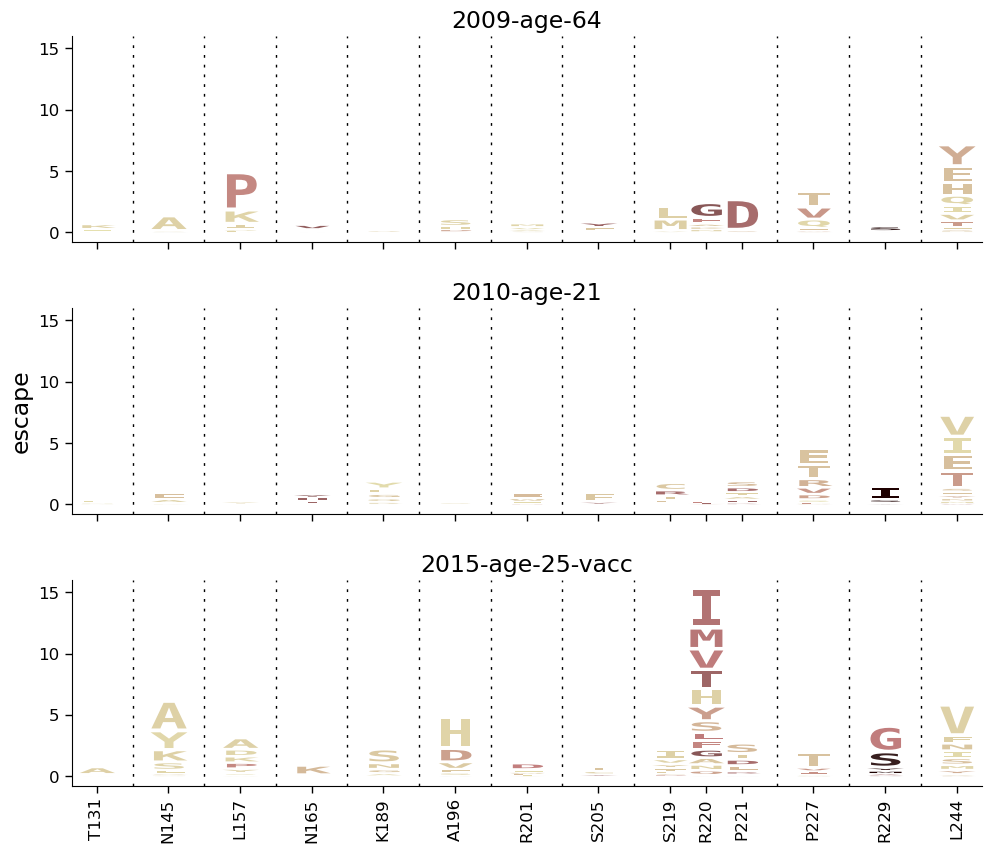

In [16]:
logoplot_df = pe09_escape_df.assign(
    color=lambda x: x['pH stability'].map(map.val_to_color),
    site_label=pe09_escape_df['wildtype'] + pe09_escape_df['site'].astype(str),
    show_site=lambda x: x["site"].isin(sites_of_interest)
).query('site not in [140, 285]')

generate_facet_logo_plot(logoplot_df, 'figures/pe09_sera_escape_logo.svg')